In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ConvNext, ViT

import trainer as train_funct
from trainer import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
writer = SummaryWriter()

In [32]:
train_funct.set_seed(42)

## Dataset

In [33]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [34]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [35]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [36]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [8]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


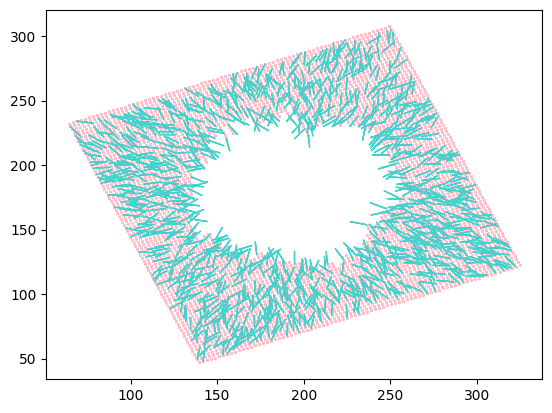

In [9]:
plotter.plot_train_data(train_data)

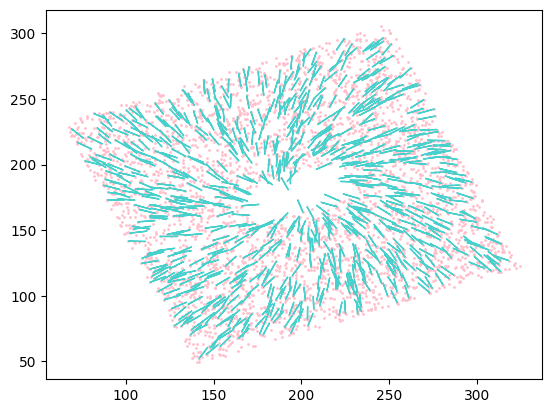

In [10]:
plotter.plot_data(val_data)

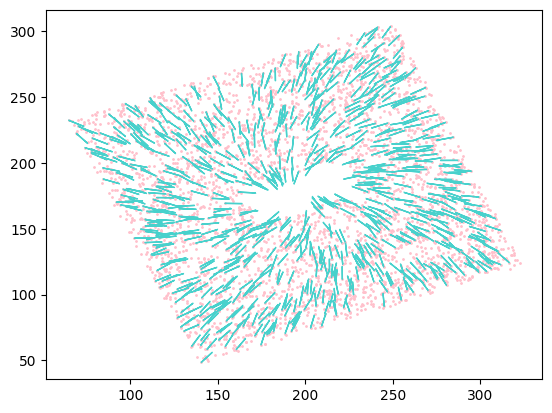

In [11]:
plotter.plot_data(test_data)

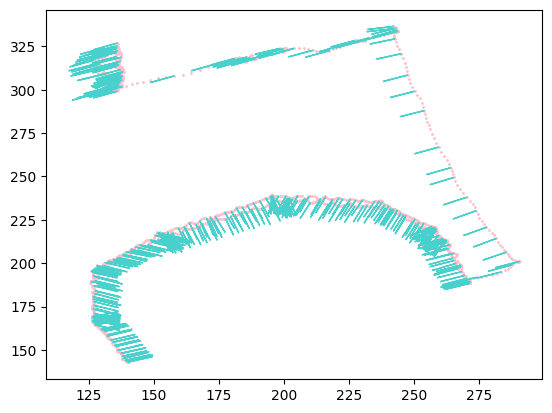

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


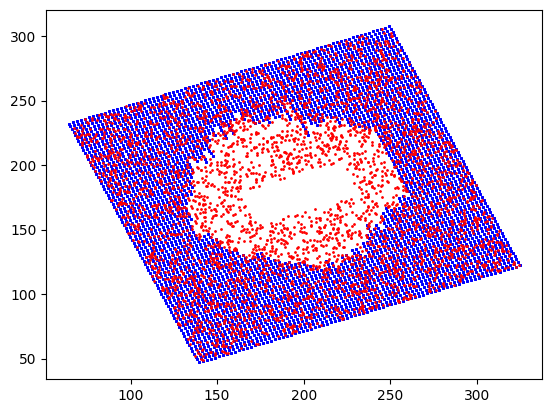

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2074.65it/s]


Validation after filtering: 3253


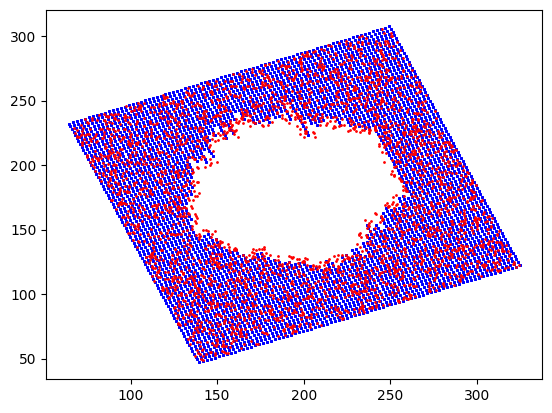

In [15]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


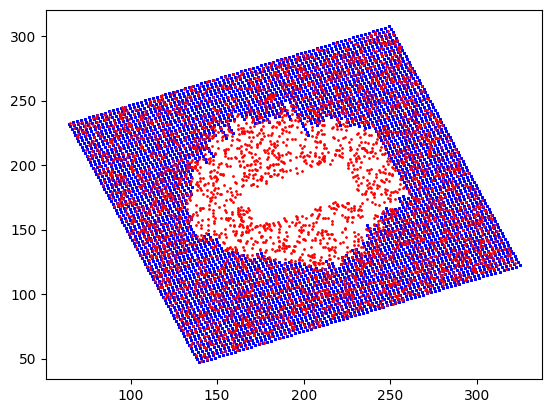

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2134.02it/s]


Test after filtering: 3271


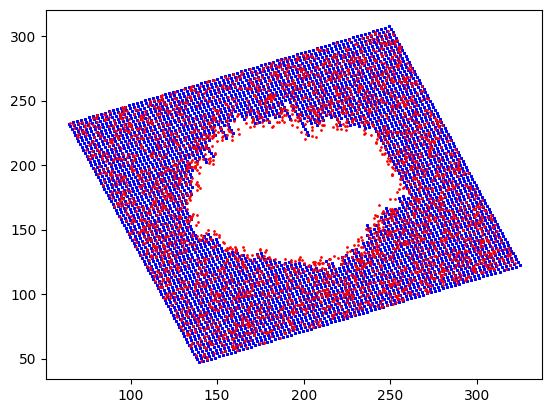

In [17]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9185888716281714
yaw difference tensor(7.2461) deg
localization error:  0.037775546 meters


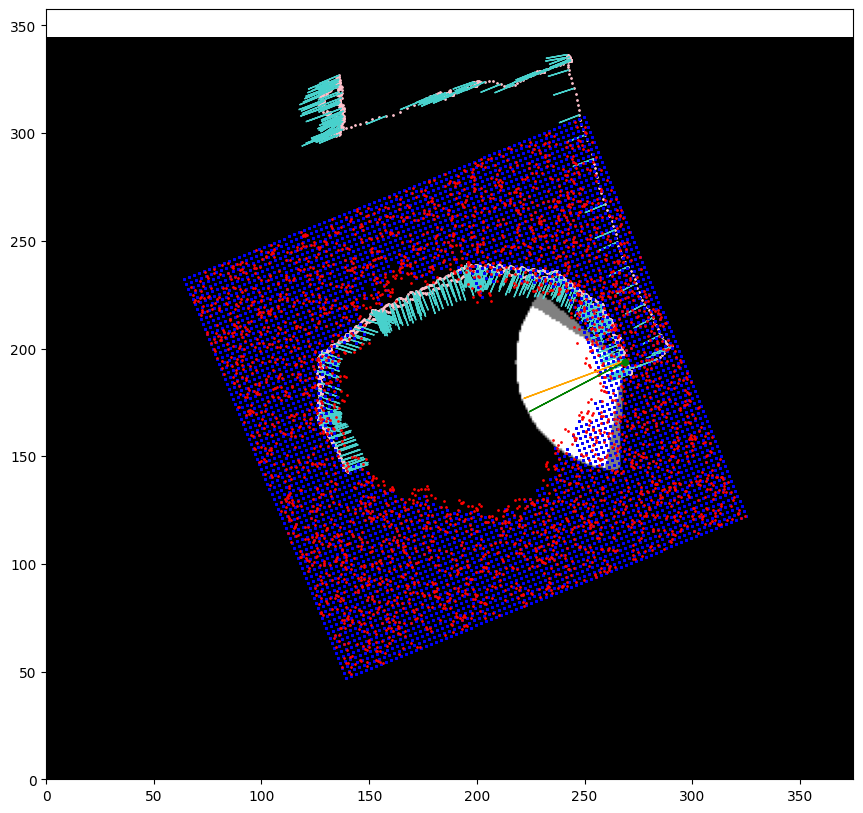

<Figure size 640x480 with 0 Axes>

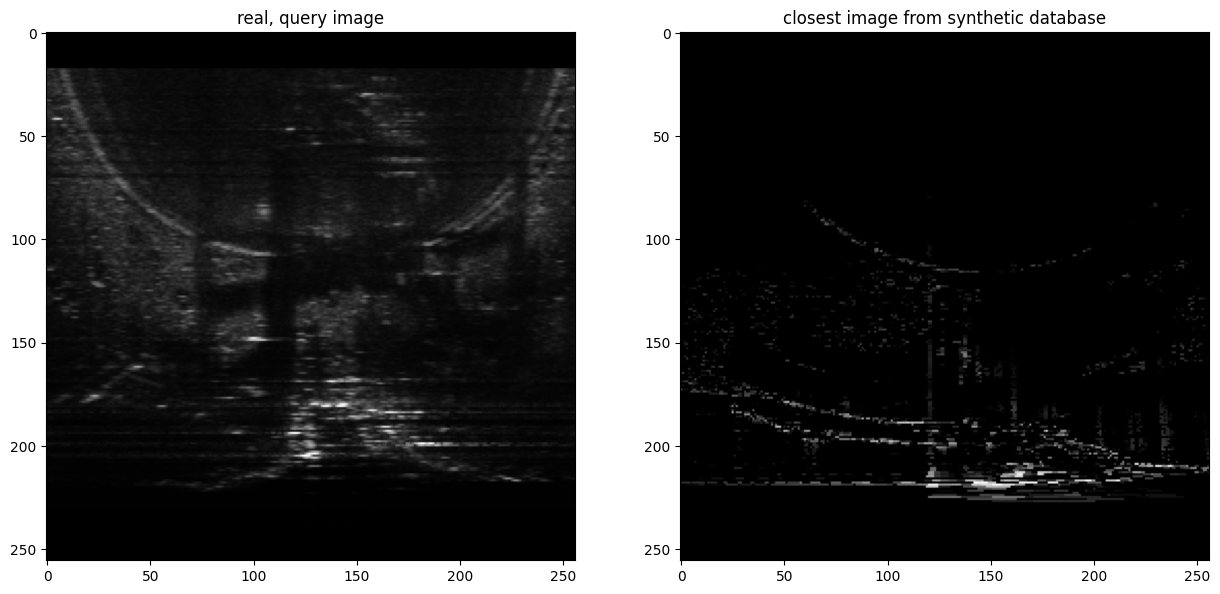

In [18]:
visualizer.localization(train_data, val_data, real_data)

In [19]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [20]:
val_data = visualizer.check_gt(train_data, val_data)

In [21]:
test_data = visualizer.check_gt(train_data, test_data)

In [22]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3267


In [23]:
model_name = "ConvNext"

In [24]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [25]:
net = ConvNext.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [26]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [27]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  2445233


## Training Pipeline

### Train epochs

In [28]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, val_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path, best_val_loca_error, best_val_orie_error = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1501/1501 [10:11<00:00,  2.45it/s]


train loss mean: 116716.2152103566
train loss reco: 116716.18147640424
train loss loca: 0.03373045404672391


100%|█████████████████████████████████████████| 204/204 [01:21<00:00,  2.49it/s]


val loss mean: 0.20439746515715823
val loss reco: 0.2026760789255301
val loss loca: 0.0017213866523496679
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:19<00:00, 300.91it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:10<00:00, 297.15it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:10<00:00,  8.79it/s]


average localization error: 2.3674 meters
average orientation error : 18.9069 degrees
epoch: 2


100%|███████████████████████████████████████| 1501/1501 [10:11<00:00,  2.45it/s]


train loss mean: 0.0723211900303159
train loss reco: 0.07151214124449963
train loss loca: 0.0008090488306450832


100%|█████████████████████████████████████████| 204/204 [01:22<00:00,  2.48it/s]


val loss mean: 0.035139989144369665
val loss reco: 0.0340076348032145
val loss loca: 0.0011323542713202472
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:18<00:00, 304.44it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:10<00:00, 296.61it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:12<00:00,  8.74it/s]


average localization error: 2.7777 meters
average orientation error : 22.6773 degrees
epoch: 3


100%|███████████████████████████████████████| 1501/1501 [10:04<00:00,  2.48it/s]


train loss mean: 0.030425548037237363
train loss reco: 0.02933932349165228
train loss loca: 0.0010862245803264492


100%|█████████████████████████████████████████| 204/204 [01:21<00:00,  2.50it/s]


val loss mean: 0.030160842609463955
val loss reco: 0.02919423591126414
val loss loca: 0.0009666067337771072
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:20<00:00, 299.68it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:10<00:00, 297.44it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:21<00:00,  8.52it/s]


average localization error: 2.5556 meters
average orientation error : 20.7230 degrees
epoch: 4


100%|███████████████████████████████████████| 1501/1501 [10:21<00:00,  2.42it/s]


train loss mean: 0.029697944542304983
train loss reco: 0.028867737313783382
train loss loca: 0.0008302072504027929


100%|█████████████████████████████████████████| 204/204 [01:27<00:00,  2.33it/s]


val loss mean: 0.028493743344191826
val loss reco: 0.027608011876616406
val loss loca: 0.0008857315071295221
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:30<00:00, 265.93it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:12<00:00, 270.12it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:55<00:00,  7.83it/s]


average localization error: 2.5345 meters
average orientation error : 20.4886 degrees
epoch: 5


100%|███████████████████████████████████████| 1501/1501 [09:54<00:00,  2.53it/s]


train loss mean: 0.023663495114441716
train loss reco: 0.022913426360603097
train loss loca: 0.0007500687439596035


100%|█████████████████████████████████████████| 204/204 [01:20<00:00,  2.55it/s]


val loss mean: 0.016868222235501103
val loss reco: 0.016049642855411068
val loss loca: 0.0008185795042806479
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:22<00:00, 290.50it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:11<00:00, 288.12it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:16<00:00,  8.64it/s]


average localization error: 2.4967 meters
average orientation error : 20.0971 degrees
epoch: 6


100%|███████████████████████████████████████| 1501/1501 [10:08<00:00,  2.47it/s]


train loss mean: 0.0107580260528769
train loss reco: 0.01003632127033729
train loss loca: 0.00072170478007228


100%|█████████████████████████████████████████| 204/204 [01:21<00:00,  2.49it/s]


val loss mean: 0.007611156388770277
val loss reco: 0.006815260356091255
val loss loca: 0.0007958960164418671
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:23<00:00, 285.88it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:11<00:00, 281.18it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:14<00:00,  8.67it/s]


average localization error: 2.4673 meters
average orientation error : 19.7754 degrees
epoch: 7


100%|███████████████████████████████████████| 1501/1501 [09:57<00:00,  2.51it/s]


train loss mean: 0.0068161407957780485
train loss reco: 0.00610608837476061
train loss loca: 0.0007100524191511873


100%|█████████████████████████████████████████| 204/204 [01:20<00:00,  2.52it/s]


val loss mean: 0.006646143384369127
val loss reco: 0.005851048773026788
val loss loca: 0.0007950946106825094
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:19<00:00, 302.47it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:10<00:00, 298.23it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:12<00:00,  8.72it/s]


average localization error: 2.4315 meters
average orientation error : 19.5662 degrees
epoch: 8


100%|███████████████████████████████████████| 1501/1501 [10:12<00:00,  2.45it/s]


train loss mean: 0.00645469957751673
train loss reco: 0.005743526671203393
train loss loca: 0.0007111729080874881


100%|█████████████████████████████████████████| 204/204 [01:20<00:00,  2.53it/s]


val loss mean: 0.006511596211816604
val loss reco: 0.005720389541238546
val loss loca: 0.0007912066799226701
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:18<00:00, 304.79it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:10<00:00, 303.11it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:18<00:00,  8.58it/s]


average localization error: 2.4071 meters
average orientation error : 19.3303 degrees
epoch: 9


100%|███████████████████████████████████████| 1501/1501 [10:00<00:00,  2.50it/s]


train loss mean: 0.0063993858010926935
train loss reco: 0.005667970364083158
train loss loca: 0.0007314154399179796


100%|█████████████████████████████████████████| 204/204 [01:20<00:00,  2.53it/s]


val loss mean: 0.006491327414051721
val loss reco: 0.005678253398989053
val loss loca: 0.0008130740225347908
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:19<00:00, 301.40it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:10<00:00, 300.41it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:24<00:00,  8.45it/s]


average localization error: 2.3721 meters
average orientation error : 19.0724 degrees
epoch: 10


100%|███████████████████████████████████████| 1501/1501 [10:22<00:00,  2.41it/s]


train loss mean: 0.006432846253384141
train loss reco: 0.0056509560657830174
train loss loca: 0.0007818901944844403


100%|█████████████████████████████████████████| 204/204 [01:27<00:00,  2.34it/s]


val loss mean: 0.0065723754050137076
val loss reco: 0.00567198937813587
val loss loca: 0.0009003860304801492
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:36<00:00, 247.95it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:13<00:00, 240.23it/s]


descriptors computed!
computing metrics


 49%|███████████████████▏                   | 1601/3251 [03:20<03:26,  7.98it/s]


KeyboardInterrupt: 

In [ ]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

In [ ]:
metrics.get_descriptors(train_data, val_data, net)

## Visualize Training results on Test data

### Load the checkpoint model

In [ ]:
checkpoint_path = best_model_path
print("Best model path: ", best_model_path)
print("Validation loca error with best model: ", best_val_loca_error)
print("Validation orie error with best model: ", best_val_orie_error)
#checkpoint_path = "correct_model_3/epoch_10.pth"
net = ConvNext.Model()
train_funct.load_state(net, checkpoint_path)

net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [ ]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

### Visualize query results: sonar images

In [ ]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

In [ ]:
visualizer.analyze_feature_robustness(train_data, net)

In [ ]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

In [ ]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

## Process real images

query_idx: 114
256.87988 220.18005 2.5348382 -34.76448


AttributeError: 'SonarDescriptorDatasetFull' object has no attribute 'descriptors'

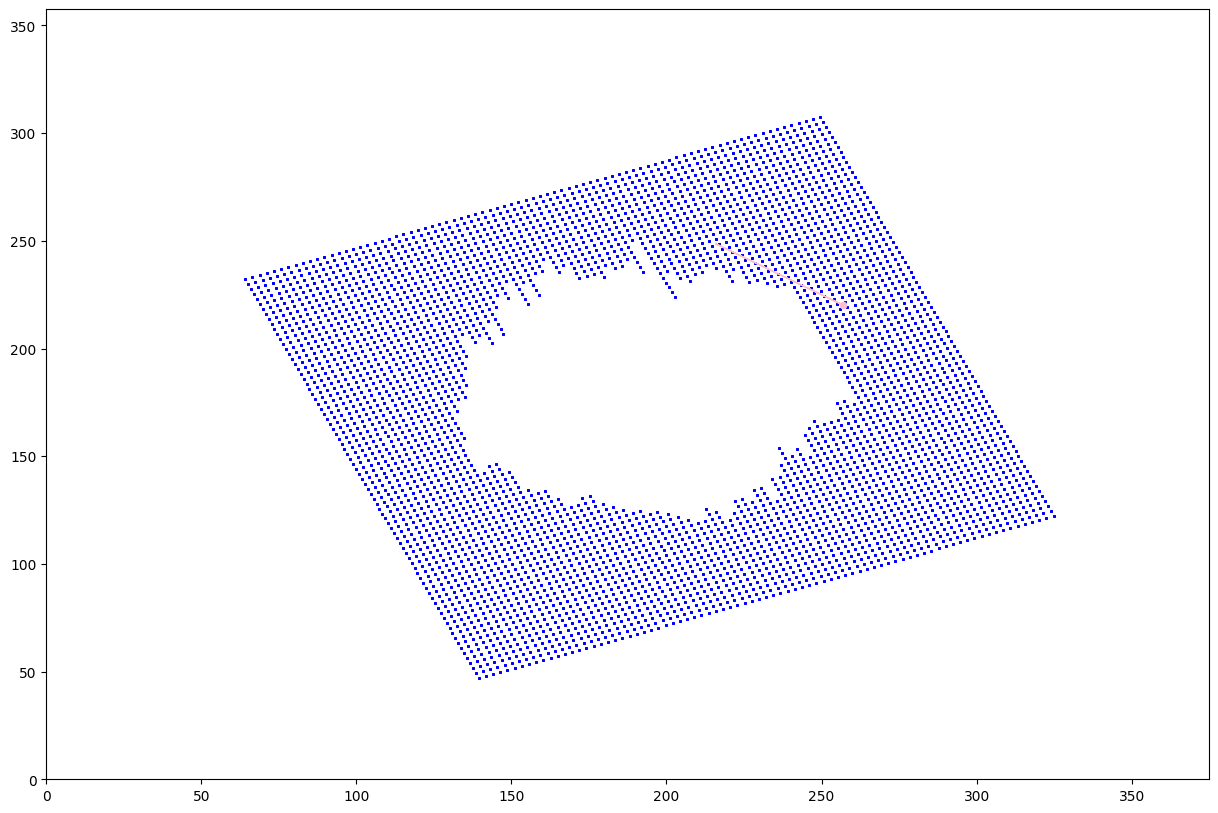

In [37]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [ ]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [ ]:
real_data_train.computeDescriptors(net)

In [ ]:
visualizer.visualize_real(train_data, real_data)

In [ ]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

In [ ]:
avg_orie_error.min()

## Results

In [ ]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")